In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import astropy.units as u
import astropy.io.fits as fits

import glob

from lsst.sims.photUtils.Sed import Sed
from lsst.sims.photUtils.Bandpass import Bandpass

import os

In [2]:
# getting this syntax right took longer than I'd like to admit:

with np.load('model_atm_mags.npz') as nump_zip:
    
    model_atm_mags = nump_zip['model_atm_mags']
    
print(model_atm_mags[0:5])

[ ( 10000., -0.5,  20., -37.60078123, -37.51868201, -37.4384572 , -37.3470091 , -36.97922705, -36.45832048, -35.90274764, -40.05998944, -40.70381931, -40.45109888, -40.21942468, -40.11126592, -39.98030254)
 ( 10000., -0.5,  25., -37.59329505, -37.51181813, -37.43043553, -37.34027532, -36.97190594, -36.45182755, -35.89520243, -40.01802394, -40.72830186, -40.45388371, -40.21356986, -40.10336677, -39.98470291)
 ( 10000., -0.5,  30., -37.59038291, -37.50938202, -37.42688391, -37.33814866, -36.96903561, -36.45048648, -35.89254622, -39.97727796, -40.73557236, -40.45419334, -40.21132305, -40.09110904, -39.98423738)
 ( 10000., -0.5,  35., -37.59042501, -37.50994626, -37.42624452, -37.33878696, -36.96927761, -36.45203998, -35.89288662, -39.937334  , -40.73377554, -40.45518354, -40.21328737, -40.07829048, -39.98193073)
 ( 10000., -0.5,  40., -37.59226817, -37.51329508, -37.42756881, -37.34125023, -36.97113322, -36.45507879, -35.89491667, -39.90158299, -40.72612635, -40.45752323, -40.21872439, -4

In [3]:
plt.style.use('ggplot')

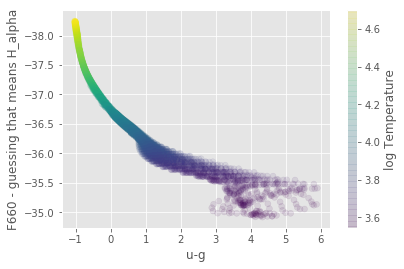

In [4]:
# Plotting one of the narrowbands to make sure it's all loaded in right.

plt.scatter(model_atm_mags['u']-model_atm_mags['r'],model_atm_mags['F660'],
            c=np.log10(model_atm_mags['Teff']), alpha=.1)
cb = plt.colorbar()
cb.set_label('log Temperature')
plt.gca().invert_yaxis()
plt.xlabel('u-g')
plt.ylabel('F660 - guessing that means H_alpha');

### Making color array:

In [5]:
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']

color_list = []

# It seems like maybe this process shouldn't be necessary to go through again, but it ended up
# being what I had to do to get the array in a form that the KD tree function was happy with.
# Oh and of course at the moment it's actually still a magnitude array. I'll get to the filter-
# subtracting later.

for star in model_atm_mags:
    
    mags = []
    
    for filt in filterlist:

        mags.append(star[filt])
    color_list.append(mags)
    
print(color_list[0:2])    

[[-40.059989441772672, -40.703819314921134, -40.45109888362424, -40.219424677455848, -40.111265919076899, -39.980302535214307], [-40.018023938221617, -40.728301864506548, -40.453883712874443, -40.213569858701405, -40.103366774223659, -39.984702913368565]]


# Now to make the KDTree(s):

In [6]:
from sklearn.neighbors import KDTree

In [7]:
color_array = np.array(color_list)
color_array.shape

(3808, 6)

In [8]:
trizzle = KDTree(color_array, leaf_size=40)

In [9]:
# Just copying the sklearn KDTree documentation examples in following cells:

dist, ind = trizzle.query(color_array[0:100], k=5)

In [10]:
print(ind[0:20])

[[   0 1911 3801 1435 1912]
 [   1 1913 1912 1437 3802]
 [   2 1914 1438 3802 1913]
 [   3 1915 3803 3804 1439]
 [   4 3804 3805 1916    5]
 [   5 3805 3806    6  480]
 [   6 3806 3807    5  481]
 [   7 1918 1442 3332 1443]
 [   8 1919 1444 1443 3333]
 [   9 1920 1445 1921 2857]
 [  10 1922 1446 1921 3335]
 [  11 1923 3336 1922 1447]
 [  12 3337   13 1924 3336]
 [  13 3338   12 3337  488]
 [  14 1449 1925  973 2863]
 [  15 1450 1926  975 1451]
 [  16 1927 1451 2864  976]
 [  17 1928 2865 1453 1452]
 [  18 1929 1930 1454 2866]
 [  19 1931 3344 1930 2867]]


In [11]:
print(dist[0:20])

[[ 0.          0.0174181   0.03033733  0.03127883  0.03162046]
 [ 0.          0.01929252  0.02169137  0.02188585  0.03011367]
 [ 0.          0.01685306  0.02307407  0.02326162  0.02705636]
 [ 0.          0.01912598  0.02224832  0.0264835   0.02946121]
 [ 0.          0.02173267  0.02379044  0.02715122  0.03247238]
 [ 0.          0.02183906  0.02289114  0.0252068   0.03232495]
 [ 0.          0.02469609  0.02516952  0.0252068   0.03460164]
 [ 0.          0.01642291  0.0176765   0.03294275  0.03571399]
 [ 0.          0.01421315  0.02100322  0.02213731  0.02963205]
 [ 0.          0.01469109  0.01686055  0.02340079  0.02696419]
 [ 0.          0.01771218  0.01918779  0.01935869  0.02459534]
 [ 0.          0.01816823  0.0224151   0.02603741  0.0267996 ]
 [ 0.          0.02199169  0.02657984  0.02912251  0.03067374]
 [ 0.          0.02496792  0.02657984  0.03012679  0.03308597]
 [ 0.          0.01073304  0.0263174   0.02991036  0.03635195]
 [ 0.          0.01197449  0.02164025  0.02355595  0.03

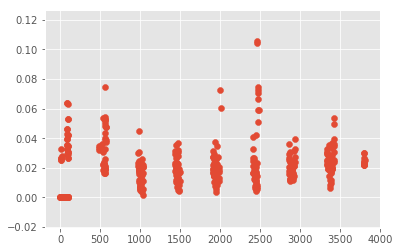

In [12]:
# I think this plot is probably messed up, but whatever.

plt.scatter(ind, dist);

### So now I could use some guidance on where to go next.

In [13]:
# OK, so next up, I think we'll want to package this up as a callable class so that 
# given observed colors and uncertainties, we return closest Teff, metallicity, logg and uncertainties.

# For example, let's say we have star 500
observed = color_array[500,:]

In [14]:
# this should return 500, since it's looking up something in the tree
dist, ind = trizzle.query(observed.reshape(1,-1), k=1)
ind

array([[500]])

In [15]:
# Now, what happens if we add some Gaussian noise to it 100 different ways. 
# I'm pretending that there's 0.05 mag error on the observation of each magnitude
observed = color_array[500,:] + np.random.randn(600).reshape(100, 6)*.05

In [16]:
dist, ind = trizzle.query(observed, k=1)

10750.0 10647.5 10750.0


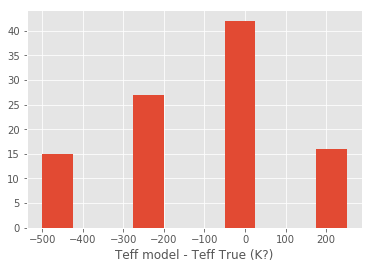

In [22]:
plt.hist(model_atm_mags['Teff'][ind]-model_atm_mags['Teff'][500])
plt.xlabel('Teff model - Teff True (K?)')
print(np.median(model_atm_mags['Teff'][ind]), np.mean(model_atm_mags['Teff'][ind]), model_atm_mags['Teff'][500])

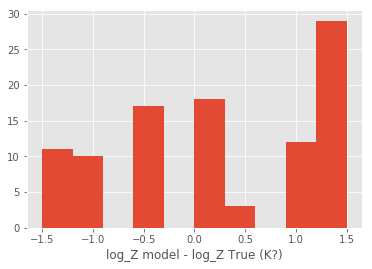

In [18]:
plt.hist(model_atm_mags['log_Z'][ind]-model_atm_mags['log_Z'][500])
plt.xlabel('log_Z model - log_Z True ()')
# I don't understand why this isn't peaked at 0. Hopefully going to colors rather than straight mags will fix that.

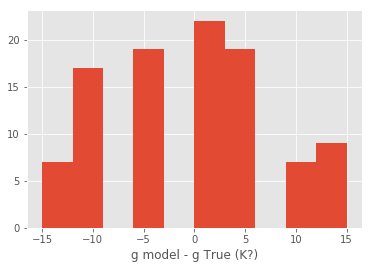

In [19]:
plt.hist(model_atm_mags['gravity'][ind]-model_atm_mags['gravity'][500])
plt.xlabel('g model - g True ()')

In [ ]:
# To stubb out the tool we'll want
class stellar_param_fitter(object):
    def __init__(self, colors=['u-g', 'g-r', 'r-i', 'i-z', 'z-y']):
        # Read in the saved array and construct the kdtree with the given colors
        self.model_atm_mags = XXX
        # Construct kdtree
        self.kdtree = XXX
    def __call__(self, input_colors):
        # Input colors could be a single measurement, or an array with 
        # Querry the kd-tree.
        dist, ind = self.kdtree.query(input_colors, k=1)
        # Construct an array to hold the results
        keys = ['Teff', 'gravity', 'log_Z']
        result = np.zeros(ind.size, dtype=list(zip(keys,[float, float, float])))
        # XXX NOTE, need to document what the units are on all these outputs!
        for key in keys:
            result[key] = self.model_atm_mags[key][ind]
        return result
    